# **FEATURE ENGINEERING**

## Objectives

* Deal with outliers, distributions, categorical encoding and numerical scale transformation to engineer dataset for machine learning task

## Inputs

* outputs/datasets/cleaned/cleaned_testset.csv
* outputs/datasets/cleaned/cleaned_trainset.csgv

## Outputs

* Feature engineering pipeline and dataset with featured variables


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/pp5_project_heritage_housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/pp5_project_heritage_housing'

---

# Rationale

Exploratory data analysis and ydataprofile report suggest the following

- Target variable (Sale price) is imbalanced, so are other variables. They have high skewness and high kurtosis
- Four categorical variables need encoding
- There are outliers. However, we don't know if they are really part of dataset or just a record error.

---

## Outliers

We should handle outlier first before appliyng transformation. The reason is that transformation can be sensitive to outliers (for example Box-Cox transformation) and in general leads to more accurate statastical analysis.

But, how we do know if an outlier is a recording error or a genuine record? 

For that, we need disucssion with other team members.

Additionally, we can assume that the dataset will update in future and it will also have outliers. So, it is best to find a way to deal with it in a pipeline rather than manually picking and removing rows.

So, for now we will consider that they are part of the database. For that reason we will choose Winsoriser instead of trimming

---

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [6]:
# read data
df_source_data=pd.read_csv("outputs/datasets/cleaned/cleaned_trainset.csv")
df=df_source_data.copy()

In [7]:
df.dtypes

1stFlrSF          int64
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtExposure     object
BsmtFinSF1        int64
BsmtFinType1     object
BsmtUnfSF         int64
GarageArea        int64
GarageFinish     object
GrLivArea         int64
KitchenQual      object
LotArea           int64
LotFrontage     float64
MasVnrArea      float64
OpenPorchSF       int64
OverallCond       int64
OverallQual       int64
TotalBsmtSF       int64
YearBuilt         int64
YearRemodAdd      int64
SalePrice         int64
dtype: object

Which variables to consider for this task?

Our exploratory analysis (PPS and correlation study) that some variables are more related to saleprice than the other. We will try to address them first. A combined list of them is

['1stFlrSF','GarageArea','GarageFinish','GrLivArea','KitchenQual','YearBuilt',
   'OverallQual','TotalBsmtSF',] 

Winsoriser can be applied to only numerical variables. So, we subset the following variables

In [8]:
win_var=['1stFlrSF','GarageArea','GrLivArea','YearBuilt','TotalBsmtSF',] 

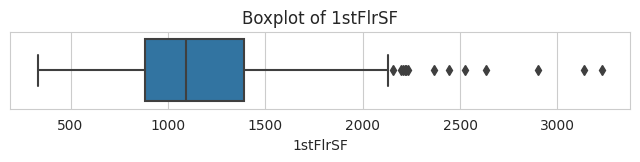

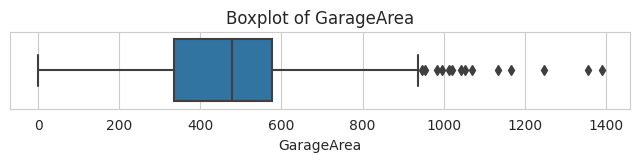

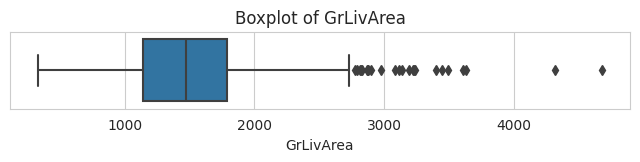

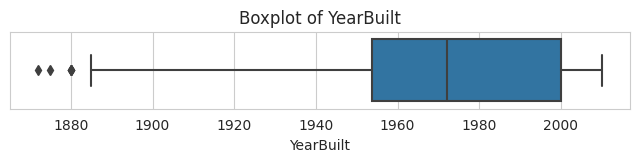

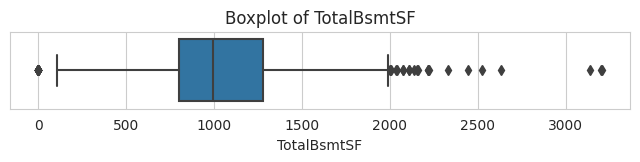

In [9]:
for var in win_var:
    plt.figure(figsize=(8,1))  # This creates a new figure on each iteration
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot of {var}')  # Optionally adding a title to each plot
    plt.show()  # This displays the figure

It looks like our distribution is heavily skewed. So, default IQR limits provided with algorithm  i.e. right tail: 75th quantile + 1.5*IQR and lef tail : 25th quantile -1.5*IQR might not capture all data.

Let's redraw plots with whisker size of 3*IQR

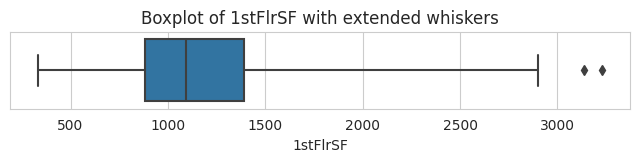

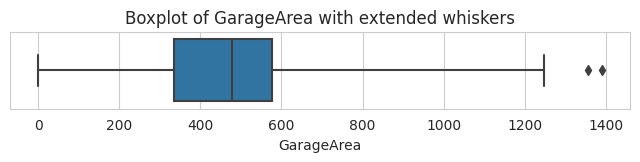

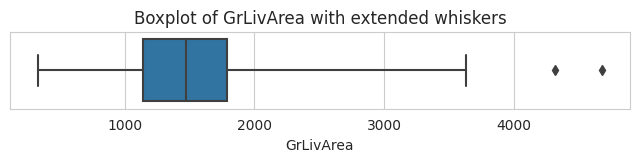

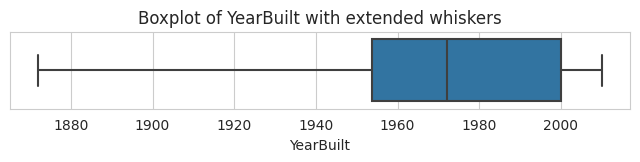

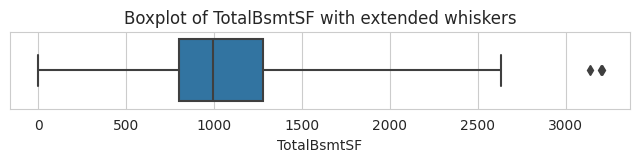

In [10]:
for var in win_var:
    plt.figure(figsize=(8,1))  
    sns.boxplot(x=df[var], whis=3)  # extending whisker to 3 times instead of default 1.5 times
    plt.title(f'Boxplot of {var} with extended whiskers')  
    plt.show()  

Extending whiskers to 3 time IQR seems to capture tail better, while leaving only a few outliers, so we will use 3 as multiplier for winsoriser transformer.

However, in the pipeline, we will aim to transform all numerical variables. Here, the most influential variables are used just to explore capping limits.

---

### Categorical encoding

We have four categories ```['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']``` that needs categorical encoding.

- Like other categories present in database, these are ordinal in nature.

- We have LabelEncoder, OneHotEncoder and OrdinalEncoder at our disposal.

- Label encoder cannot be used because as per the official documentation (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) , it should be used to transform target values and note input.

- OnehotEncoder, when applied to four categories, can lead to many columns generation, which can be computationally heavy.

- **Consdering other categorical variables in our dataset are ranked as integers, we can choose Ordinal encoder. We will use arbitrary assignment of integers. This is okay, as long as we are using Tree based algorithms and ensamble methods, which are tolerant to it**

### Dealing with non-normal distribution

Ydataprofile report suggests some numerical variables to be skewed, some have high kurtosis, some are having bimodal distribution. So, we will need to apply transformation to bring them to normal or uniform distribution. 

We will use a custom function to evaluate which transformations are best suited for given data.

### Plotting and analysis

In [11]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop in each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng,list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing value in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(4, 3))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show()
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.tight_layout()
  plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=3, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked

Let's begin with categorical encoding

In [12]:
variables_engineering= ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
df_engineering = df[variables_engineering].copy()
df_engineering.head()

,BsmtExposure,BsmtFinType1,GarageFinish,KitchenQual
0,Av,Unf,Unf,Gd
1,No,Unf,None,TA
2,No,ALQ,Unf,TA
3,No,GLQ,RFn,Gd
4,No,Unf,RFn,Gd


* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



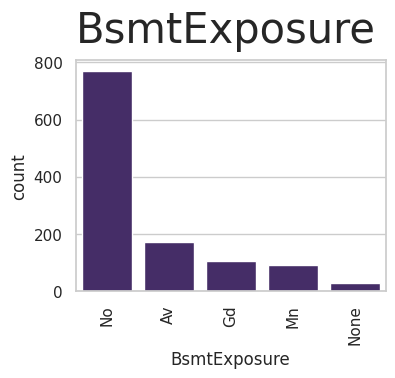

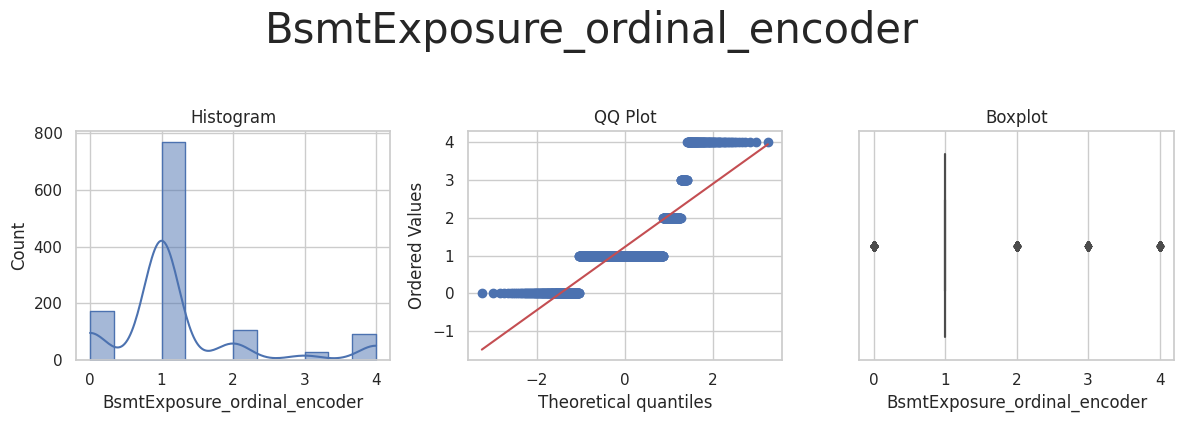



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



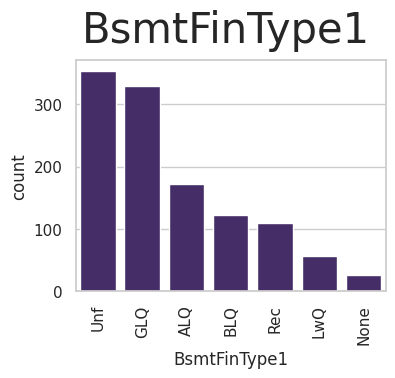

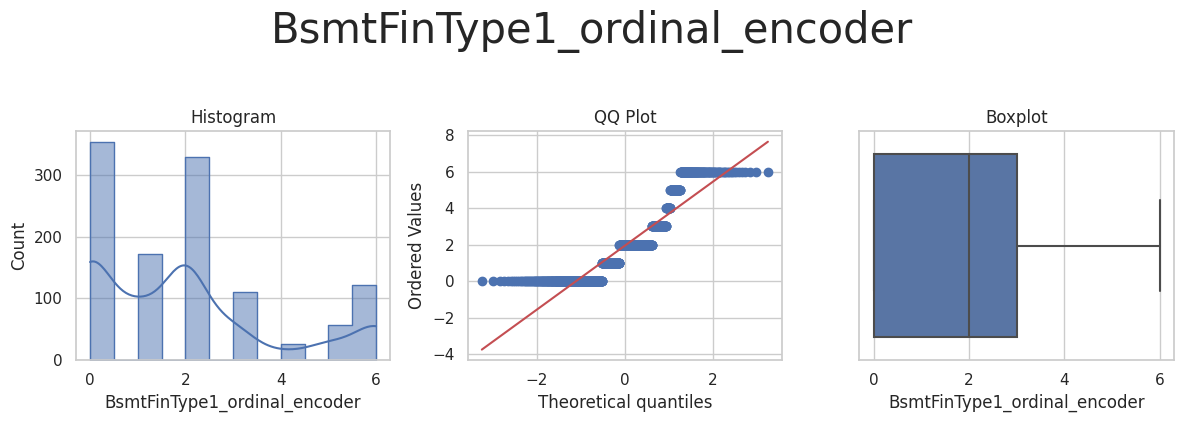



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



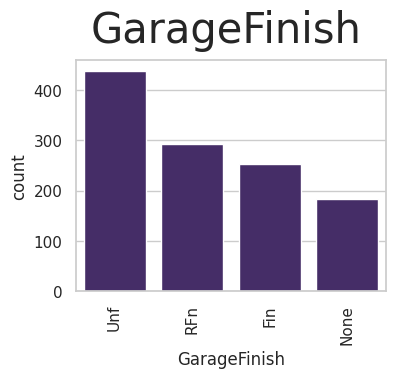

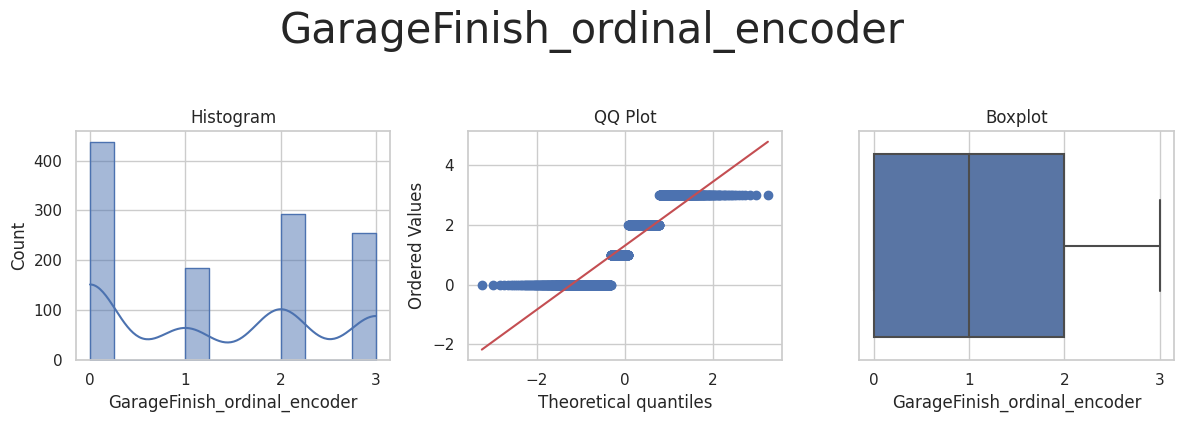



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



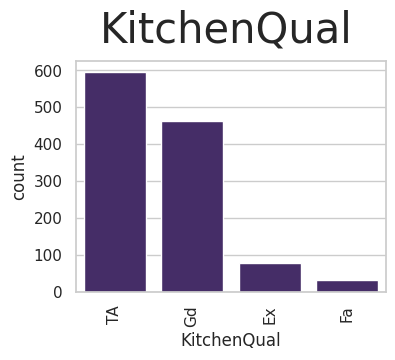

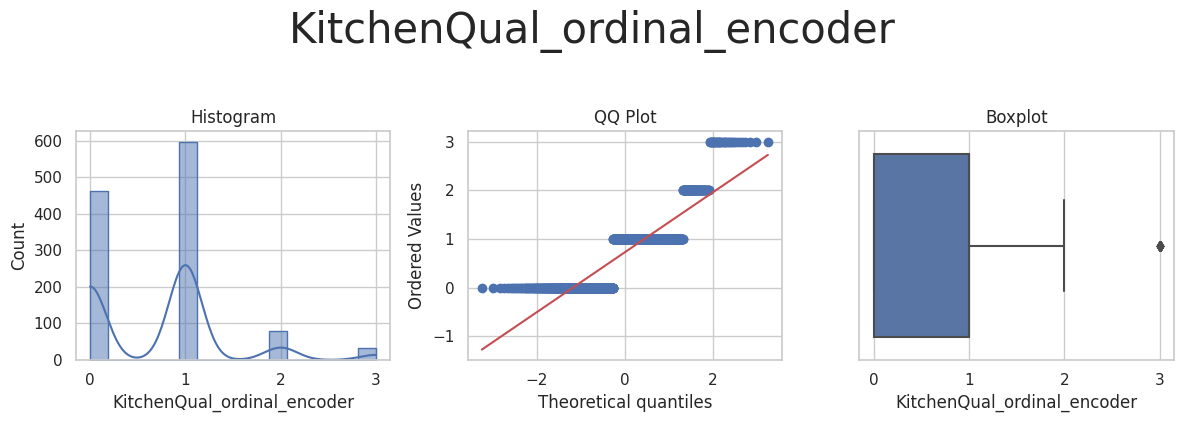

In [13]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')


### Numerical Transformation

We

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
